# Simulate future prices

We download the prices history for the stocks. Each stock is identify with a ``Ticker`` with is an abbreviation of the stock name.  
In order to do that we use the ``pandas_datareader`` library that permit to download stocks prices from Yahoo Finance Data.

In [1]:
from datetime import datetime
import pandas_datareader.data as web

stocks = ["ge", "intc", "amd", "gold", "spy", "ko", "pep"]
start, end = datetime(2017, 1, 1), datetime(2020, 1, 1)
df = web.DataReader(stocks, "yahoo", start=start, end=end)
df_prices = df["Adj Close"]

Let's define some expected anual returns ``era`` and a number of simulated prices ``spn`` to predict for each stock previously download.

In [2]:
ear = {
    "ge": -0.8,
    "intc": 10,
    "amd": -0.1,
    "gold": -0.5,
    "spy": -0.99,
    "ko": 0.08,
    "pep": 0.01,
}
spn = 254

Now prepare the simulation.
1. check that the ``df_prices`` contains prices.
2. Instantiate the ``simulation`` object.

In [3]:
%load_ext autoreload
%autoreload 2
from simustocks.stocks import Stocks
from simustocks.simulation import Simulation

stocks_history = Stocks(df=df_prices)

simulation = Simulation(stocks_history, er=ear, m=spn)

We are ready to run the simulation.

In [4]:
future_returns, future_cov, future_prices = simulation(order=12)

To visualize the results we can plot the historical prices follow by the simulated ones on the same plot.

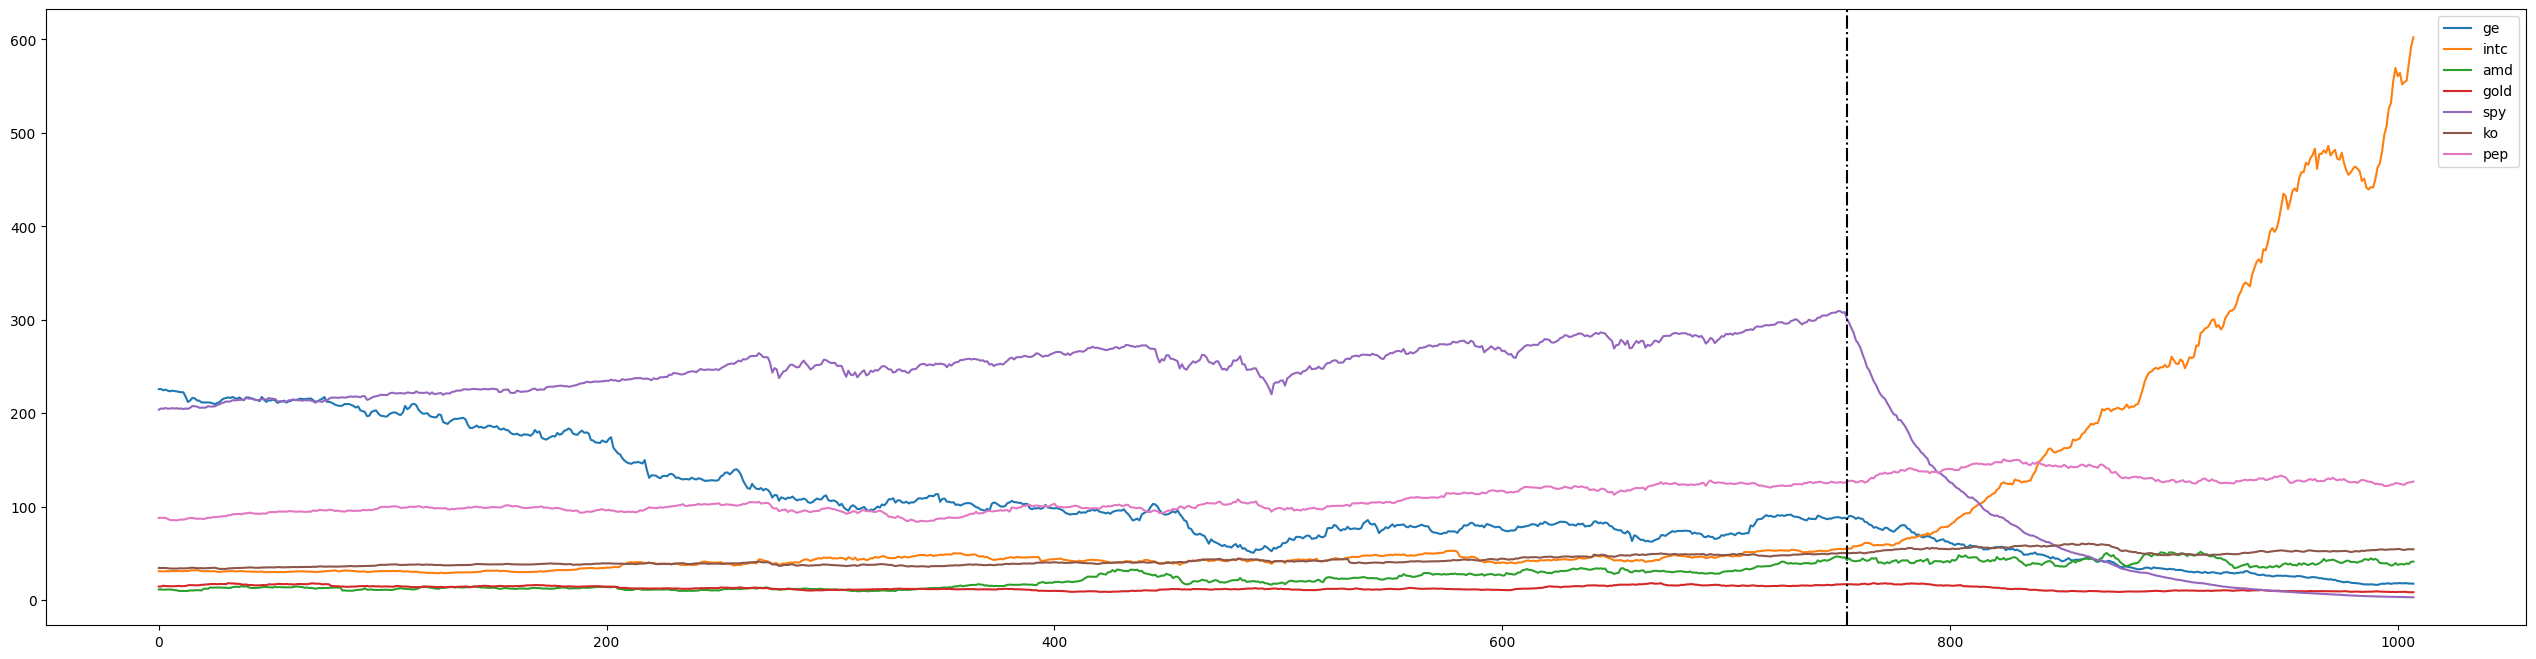

In [5]:
import numpy as np
import matplotlib.pyplot as plt

n = stocks_history.df.to_numpy().shape[0]
m = future_prices.shape[0]

# legend
stocks_names = stocks_history.df.columns
k = len(stocks_names)

prices = np.vstack((stocks_history.prices.T, future_prices[1:, :]))  # shape (n + m, k)

fig, ax = plt.subplots(figsize=(32, 8))
ax.plot(prices, label=stocks_names)
ax.axvline(x=n, ymin=0, ymax=1, c="black", linestyle="-.")
ax.legend();

To be sure that all is as expected we verify that:

1. The covariance of the daily returns of our simulated prices are the same as the historical one.

In [6]:
sar = future_prices[-1, :] / future_prices[0, :] - 1  # Simulated anual returns
dar = np.array(list(ear.values()))  # desired anual returns
assert np.allclose(sar, dar)

2. The anual returns of the each simulated stock are the same as the given ones.

For that we can write a simple function call ``get_daily_returns()`` to compute the daily returns given an array of prices.

In [7]:
import numpy.typing as npt


def get_daily_returns(array: npt.NDArray) -> npt.NDArray:
    # array: shape (n, k)
    # output: shape (n-1, k)
    return np.diff(array, axis=0) / array[:-1, :]

Check that the covariance are identical.

In [8]:
future_returns = get_daily_returns(future_prices)
history_returns = get_daily_returns(stocks_history.prices.T)
future_cov = np.cov(future_returns.T)
history_cov = np.cov(history_returns.T)
assert np.allclose(history_cov, future_cov)